In [1]:
!pip install requests beautifulsoup4

In [2]:
# live scraping
import requests 
from bs4 import BeautifulSoup
from selenium import webdriver
import time
import json

#  classification
from fastai.vision.all import *

#  recommendation
import numpy as np
from collections import defaultdict
import pandas as pd

In [3]:
class Classification_Recommendation():
    def __init__(self):
        self.n = settings['n']
        self.eta = settings['learning_rate']
        self.epochs = settings['epochs']

    
    
    def access_webpage(self, url):
        driver = webdriver.Chrome('./chromedriver') 
        driver.get(url)
        html = driver.page_source 
#         print(html)
        soup = BeautifulSoup(html, 'html.parser')
        
        return soup
    
    
    
    def scrape_data(self, container, items, item_len):
        item_n = [] 
        item_link = []
        item_img = []
        item_price = []
        
        i = 0
        while i != item_len:
            for div in container:
                for item in items:
                    
                    img_len = len(items[2])
                    item_name = item[0].lower()
                    
                    data_fetched = div.findAll(item[1], class_ = item[2])

                    if item_name == 'name':
                        item_n.extend(data_fetched)
                    elif item_name == 'link':
                        item_link.extend(data_fetched)
                    elif item_name == 'image':
                        item_img.extend(data_fetched)
                    elif item_name == 'price':
                        item_price.extend(data_fetched)
                    
                    
                i += 1
                if i == item_len:
                    break
                    
                    
        return  item_n, item_link, item_img, item_price
        
        
        
    def Filter(self, item_n, item_link, item_img, item_price):
        names = []
        prices = []
        links = []
        imgs = []
        
        for name in item_n:
            names.append(name.get_text())
            
        for link in item_link:
            links.append(link['href'])
            
        for price in item_price:
            prices.append(price.get_text())
            
        for img in item_img:
            imgs.append(img['src'])
        
        
        return names, prices, links, imgs
            
            
        
#  fetch items    
    def scrape(self, directories):        
        self.dataset = []
        
        for c in range(len(directories)):
            f = open(directories[c])
            parameters = json.load(f)
            
            
            for param in parameters:
                time.sleep(5)
                
                soup = self.access_webpage(param['url'])
                
                con = param['main_container']
                container = soup.findAll(con[0], class_ = con[1])
#                 print(container)
                item_n, item_link, item_img, item_price = self.scrape_data(container, param['fetch_data_item'], param['item_len'])
                
                names, prices, links, imgs = self.Filter(item_n, item_link, item_img, item_price)


                for i in range(param['item_len']):
                    data = {
                        'Name': names[i],
                        'Price': prices[i],
                        'Image': imgs[i],
                        'Link' : links[i],
                        'Category': param['Category'],
                        'Store' : param['Store'],
                        'Gender' : param['Gender']
                    }

                    self.dataset.append(data)
                    
                print('Store:',param["Store"]    ,'Item:',param["Category"],' Gender:',param["Gender"])
            
        return self.dataset
    
    
    
    
    def CM_Models(self, gender, img):
        cm_path = "C:\\Users\\emielou\\Desktop\\scraping\\ClassificationModels\\"

        if gender.lower() == 'men':
            cmodel = load_learner(f'{cm_path}m_img\\mfashion_classification.pkl')
        else:
            cmodel = load_learner(f'{cm_path}w_img\\wfashion_classification.pkl')

        img_fashiontype = cmodel.predict(item = img)

        return img_fashiontype[0], gender
    
    
    
    
    def display_classified(self, dataset, img_category, gender, fashion_types):
        f_type = []
        
        for fitem in fashion_types:
            for item in fitem['Fashion_items'][0]:
                if item.lower() == img_category.lower() and fitem['Gender'].lower() == gender.lower():
                    f_type.extend(fitem['Fashion_items'][1])
        
        
        display_items = []
        
        for data in dataset: 
            for ftype in f_type:
                if data['Category'].lower() == ftype.lower() and data['Gender'].lower() == gender.lower():
                    display_items.append(data)
        
        
        return display_items
    
    
    
    
    def generate_training_data(self, dataset):
        data_pairs = []

        for item in dataset:
            X = item['Name']
            Y = [item['Price'], item['Gender'], item['Category'], item['Store']]
            data_pairs.append([X,Y])


        count = defaultdict(int)
        c_item = defaultdict(int)
        
        for data in data_pairs:
            count[data[0]] + 1
            c_item[data[0]] + 1

            for yc in data[1]:
                count[yc] +1

        self.len_d = len(count.keys())
        
        self.list_x = sorted(list(count.keys()), reverse=False)
        self.x_index = {x:i for (i, x) in enumerate(self.list_x)}  
        self.index_x = {i:x for (i, x) in enumerate(self.list_x)}


        training_data = []
        for data in data_pairs:
            target = self.x_index[data[0]]
            i_target = [0 for i in range(0, self.len_d )]

            i_target[target] = 1

            i_content = []
            for y_data in data[1]:
                content = self.x_index[y_data]
                item_content = [0 for i in range(0, self.len_d )]
                item_content[content] = 1

                i_content.append(item_content)

            training_data.append([i_target, i_content])


        return np.array(training_data, dtype=object)
    
    
       
    
    def softmax(self, X):
        e_x = np.exp(X - np.max(X))
        return e_x / e_x.sum(axis=0)

    
        

    def forward_pass(self, x):
        h = np.dot(self.w1.T, x)
        u = np.dot(self.w2.T, h)
        y_c = self.softmax(u)
        return y_c, h, u
                

        
        
    def backprop(self, e, h, x): 
        dl_dw2 = np.outer(h, e)  
        dl_dw1 = np.outer(x, np.dot(self.w2, e.T))

        self.w1 = self.w1 - (self.eta * dl_dw1)
        self.w2 = self.w2 - (self.eta * dl_dw2)
        
        pass
    
    
    
    
    
    def train(self, dataset):
        training_data = self.generate_training_data(dataset)
        
        self.w1 = np.random.uniform(-1, 1, (self.len_d, self.n) )
        self.w2 = np.random.uniform(-1, 1, (self.n, self.len_d) )
             
        self.loss = 0

        
        for i in range(self.epochs):

            for data in training_data:
                y_pred, h, u = self.forward_pass(data[0])
                
                EI = np.sum([(y_pred - y) for y in data[1]], axis=0)
                self.backprop(EI, h, data[0])

                self.loss =  -np.sum([u[y.index(1)] for y in data[1]]) + len(data[1]) * np.log(np.sum(np.exp(u)))
                 
            print('Iteration: ',i, ' Loss: ', self.loss)

        pass
    
    
    
    
    def word_vec(self, item):
        i_index = self.x_index[item]
        item_vec = self.w1[i_index]
        
        return item_vec
    
    

                
    
    def recommendation(self, dataset, item, item_len):
        item_name = []
        item_embed = []
        item_sim = {}
        
        v_w1 =  self.word_vec(item)
        
        for data in dataset:
            item_name.append(data['Name'])
            item_embed.append(self.word_vec(data['Name']))
            
        
        for i in range(len(item_name)):
            v_w2 = item_embed[i]
            A = np.dot(v_w1, v_w2)
            B = np.linalg.norm(v_w1) * np.linalg.norm(v_w2)
            theta = A / B
            
            item = item_name[i]
            item_sim[item] = theta

       
        item_sorted = sorted(item_sim.items(), key=lambda kv: kv[1], reverse=True)

        
        get_name = []
        get_sim = []
        
        for items, sim in item_sorted[:item_len]:
            get_name.append(items)
            get_sim.append(sim)
            
            
        get_idata = []
        for data in dataset:
            for name in get_name:
                if data["Name"] == name:
                    get_idata.append(data)
            
        return get_idata


#    FOR RESULT VISUALITION

    def cosine_similarity(self, word1, word2):
        a=self.word_vec(word1)
        b=self.word_vec(word2)
        dot_product = np.dot(a, b)
        norm_a = np.linalg.norm(a)
        norm_b = np.linalg.norm(b)
        return np.dot(a, b)/np.sqrt(np.dot(a, a)*np.dot(b, b))
        return dot_product / (norm_a * norm_b)

    
    
    def mapping(self, dataset):
        item_name = []
        Embedingarray= [] 

        for data in dataset:
            item_name.append(data['Name'])


         
        Values=np.zeros((len(item_name), len(item_name))) # size match to wordsArray
        for i in range(len(item_name)):
            for j in range(len(item_name)):
                Values[i][j]=self.cosine_similarity(item_name[i], item_name[j])
                #print(WordsArray[i], WordsArray[j],Values[i][j])
            Embedingarray.append(self.word_vec(item_name[i]))
        cos_mtx = pd.DataFrame(data=Values,columns=item_name,index=item_name)
        
        return cos_mtx

In [4]:
settings = {
    'n': 100,
    'epochs': 250,
    'learning_rate': 0.01
}

In [5]:
srp = Classification_Recommendation()

In [6]:
Sport_fashion_style = ['C:/Users/emielou/Desktop/scraping/Queries/Sport_fashion_style.json'] 

In [7]:
Stylish_fashion_style = ['C:/Users/emielou/Desktop/scraping/Queries/Stylish_fashion_style.json'] 

In [8]:
Modern_fashion_style = ['C:/Users/emielou/Desktop/scraping/Queries/Modern_fashion_style.json'] 

In [9]:
Creative_fashion_Style = ['C:/Users/emielou/Desktop/scraping/Queries/Creative_fashion_Style.json'] 

In [10]:
Stylish_fashion_style_Data = srp.scrape(Stylish_fashion_style)

C:\Users\emielou\AppData\Local\Temp\ipykernel_22708\4256168959.py:10: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('./chromedriver')


Store: Flipkart Item: Dress  Gender: Woman
Store: Flipkart Item: Jeans  Gender: Woman
Store: Flipkart Item: Shirts  Gender: Woman
Store: Flipkart Item: Shorts  Gender: Woman
Store: Flipkart Item: Party dress  Gender: Woman
Store: Flipkart Item: Winter Coats  Gender: Woman
Store: Flipkart Item: Trousers  Gender: Woman
Store: Flipkart Item: Skirts  Gender: Woman
Store: Flipkart Item: Jeans  Gender: Men
Store: Flipkart Item: Shirts  Gender: Men
Store: Flipkart Item: Shorts  Gender: Men
Store: Flipkart Item: Party wear  Gender: Men
Store: Flipkart Item: Winter Coats  Gender: Men
Store: Flipkart Item: Trousers  Gender: Men


In [11]:
Modern_fashion_style_Data = srp.scrape(Modern_fashion_style)

C:\Users\emielou\AppData\Local\Temp\ipykernel_22708\4256168959.py:10: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('./chromedriver')


Store: Flipkart Item: Bags  Gender: Woman
Store: Flipkart Item: Casual t-shirt  Gender: Woman
Store: Flipkart Item: Printed t-shirt  Gender: Woman
Store: Flipkart Item: Summer Cloth  Gender: Woman
Store: Flipkart Item: Swimwear  Gender: Woman
Store: Flipkart Item: Night dress  Gender: Woman
Store: Flipkart Item: Bags  Gender: Men
Store: Flipkart Item: Casual t-shirt  Gender: Men
Store: Flipkart Item: Printed t-shirt  Gender: Men
Store: Flipkart Item: Summer cloths  Gender: Men
Store: Flipkart Item: Swimwear  Gender: Men


In [12]:
Creative_fashion_Style_Data = srp.scrape(Creative_fashion_Style)

C:\Users\emielou\AppData\Local\Temp\ipykernel_22708\4256168959.py:10: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('./chromedriver')


Store: Flipkart Item: Boots  Gender: Woman
Store: Flipkart Item: Jacket  Gender: Woman
Store: Flipkart Item: Polo Shirt  Gender: Woman
Store: Flipkart Item: Vest  Gender: Woman
Store: Flipkart Item: Coats  Gender: Woman
Store: Flipkart Item: Pants  Gender: Woman
Store: Flipkart Item: Boots  Gender: Men
Store: Flipkart Item: Jacket  Gender: Men
Store: Flipkart Item: Polo Shirt  Gender: Men
Store: Flipkart Item: Vest  Gender: Men
Store: Flipkart Item: Coats  Gender: Men
Store: Flipkart Item: Pants  Gender: Men


In [13]:
Sport_fashion_style_Data = srp.scrape(Sport_fashion_style)

C:\Users\emielou\AppData\Local\Temp\ipykernel_22708\4256168959.py:10: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('./chromedriver')


Store: Flipkart Item: Sports bra  Gender: Woman
Store: Flipkart Item: Sport shoes  Gender: Woman
Store: Flipkart Item: Sports bag  Gender: Woman
Store: Flipkart Item: activewear  Gender: Woman
Store: Flipkart Item: Trunks  Gender: Woman
Store: Flipkart Item: Jugging Pants  Gender: Woman
Store: Flipkart Item: Sport shoes  Gender: Men
Store: Flipkart Item: Sports bag  Gender: Men
Store: Flipkart Item: activewear  Gender: Men
Store: Flipkart Item: Trunks  Gender: Men
Store: Flipkart Item: Jugging Pants  Gender: Men


In [14]:
# DISPLAY ITEMS BY GENDER
dataset = []
scraped_data = [Sport_fashion_style_Data, Creative_fashion_Style_Data, Modern_fashion_style_Data, Stylish_fashion_style_Data]

for sdata in scraped_data:
    for data in sdata:
        dataset.append(data)

In [15]:
len(dataset)

480

In [16]:
img_path = 'C:\\Users\\emielou\\Desktop\\scraping\\ClassificationModels\\Trial_Image\\dress1.jpg'

In [17]:
category, gender= srp.CM_Models('woman', img_path)

In [18]:
category

'Stylish_Style'

In [19]:
fashion_type_dir = 'C:/Users/emielou/Desktop/scraping/Queries/fashion_type.json'

In [20]:
f = open(fashion_type_dir)
fashion_types = json.load(f)      

In [21]:
# ITEMS FOR CLASSIFICATION PREDICTION
display_items = srp.display_classified(dataset, category, gender, fashion_types)

In [22]:
srp.train(dataset)

Iteration:  0  Loss:  33.27660155044076
Iteration:  1  Loss:  19.074581116424508
Iteration:  2  Loss:  12.890659804108225
Iteration:  3  Loss:  11.057760337835497
Iteration:  4  Loss:  10.37662591370053
Iteration:  5  Loss:  10.01271628545215
Iteration:  6  Loss:  9.697246595020317
Iteration:  7  Loss:  9.421555646164066
Iteration:  8  Loss:  9.210396151210091
Iteration:  9  Loss:  9.035735822552098
Iteration:  10  Loss:  8.858997831879918
Iteration:  11  Loss:  8.6865625437324
Iteration:  12  Loss:  8.53351217055733
Iteration:  13  Loss:  8.405648384953544
Iteration:  14  Loss:  8.302623876704622
Iteration:  15  Loss:  8.221145624316073
Iteration:  16  Loss:  8.157142323035735
Iteration:  17  Loss:  8.107003102954337
Iteration:  18  Loss:  8.0675278940246
Iteration:  19  Loss:  8.03589887885331
Iteration:  20  Loss:  8.009968185747468
Iteration:  21  Loss:  7.9883663271525265
Iteration:  22  Loss:  7.970283843558093
Iteration:  23  Loss:  7.955218089963893
Iteration:  24  Loss:  7.942

Iteration:  198  Loss:  7.822777017311317
Iteration:  199  Loss:  7.822735558578927
Iteration:  200  Loss:  7.8226945184676
Iteration:  201  Loss:  7.8226538888732335
Iteration:  202  Loss:  7.822613661866498
Iteration:  203  Loss:  7.8225738296884515
Iteration:  204  Loss:  7.822534384745964
Iteration:  205  Loss:  7.822495319607576
Iteration:  206  Loss:  7.822456626999383
Iteration:  207  Loss:  7.822418299800937
Iteration:  208  Loss:  7.822380331041487
Iteration:  209  Loss:  7.822342713896205
Iteration:  210  Loss:  7.82230544168241
Iteration:  211  Loss:  7.822268507856201
Iteration:  212  Loss:  7.822231906008909
Iteration:  213  Loss:  7.822195629863771
Iteration:  214  Loss:  7.822159673272743
Iteration:  215  Loss:  7.822124030213303
Iteration:  216  Loss:  7.822088694785492
Iteration:  217  Loss:  7.822053661208791
Iteration:  218  Loss:  7.822018923819421
Iteration:  219  Loss:  7.821984477067396
Iteration:  220  Loss:  7.821950315513902
Iteration:  221  Loss:  7.821916433

Iteration:  394  Loss:  7.817838733098547
Iteration:  395  Loss:  7.817818409924257
Iteration:  396  Loss:  7.8177980855764915
Iteration:  397  Loss:  7.817777759780277
Iteration:  398  Loss:  7.817757432265104
Iteration:  399  Loss:  7.817737102764937
Iteration:  400  Loss:  7.817716771018084
Iteration:  401  Loss:  7.817696436767136
Iteration:  402  Loss:  7.8176760997588985
Iteration:  403  Loss:  7.81765575974444
Iteration:  404  Loss:  7.817635416478922
Iteration:  405  Loss:  7.817615069721512
Iteration:  406  Loss:  7.817594719235444
Iteration:  407  Loss:  7.817574364787859
Iteration:  408  Loss:  7.817554006149834
Iteration:  409  Loss:  7.817533643096205
Iteration:  410  Loss:  7.817513275405659
Iteration:  411  Loss:  7.817492902860572
Iteration:  412  Loss:  7.8174725252470125
Iteration:  413  Loss:  7.817452142354654
Iteration:  414  Loss:  7.817431753976763
Iteration:  415  Loss:  7.817411359910096
Iteration:  416  Loss:  7.817390959954913
Iteration:  417  Loss:  7.817370

In [38]:
#  DISPLAY ITEMS COSINE SIMILARITY MATRIX
import seaborn as sns

def mapp(dataset):
    mapped_items = srp.mapping(dataset)
    sns.set(rc={"figure.figsize":(25, 25)}) 
    sns.heatmap(mapped_items, annot=True, annot_kws={"size":13})

In [39]:
#  ADD ELIF STATEMENT FOR EVERY ITEM CATEGORIES
Sports_bra = []
Sport_shoes = []
for data in dataset:
    if data['Category'] == 'Sports bra':
        Sports_bra.append(data)
    elif data['Category'] == 'Sport shoes':
        Sport_shoes.append(data)

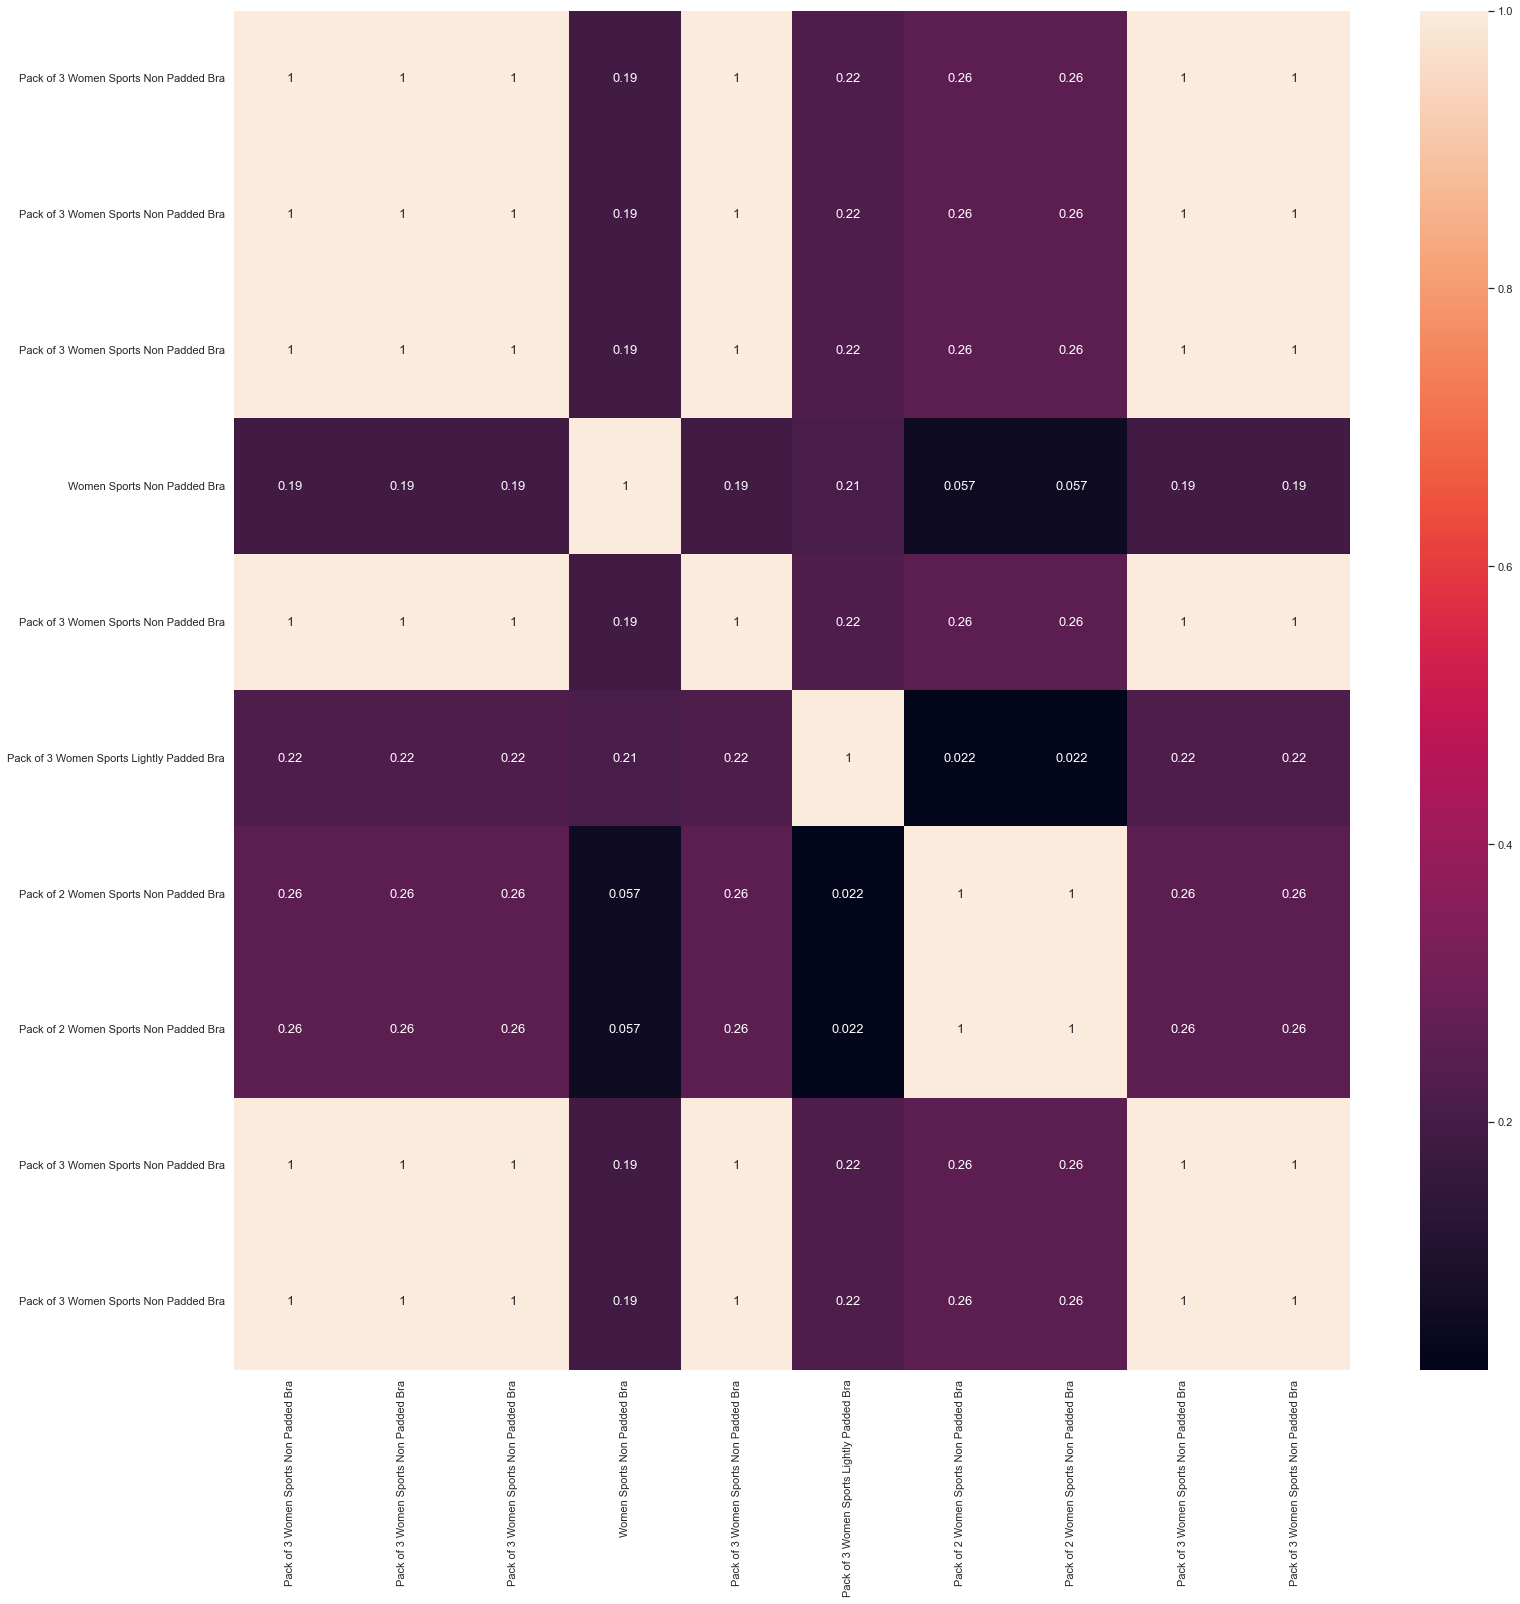

In [41]:
# APPLY MAPP FUNCTION TO EVERY ARRAY OF ITEMS TO GET THE FIGURE 
mapp(Sports_bra)

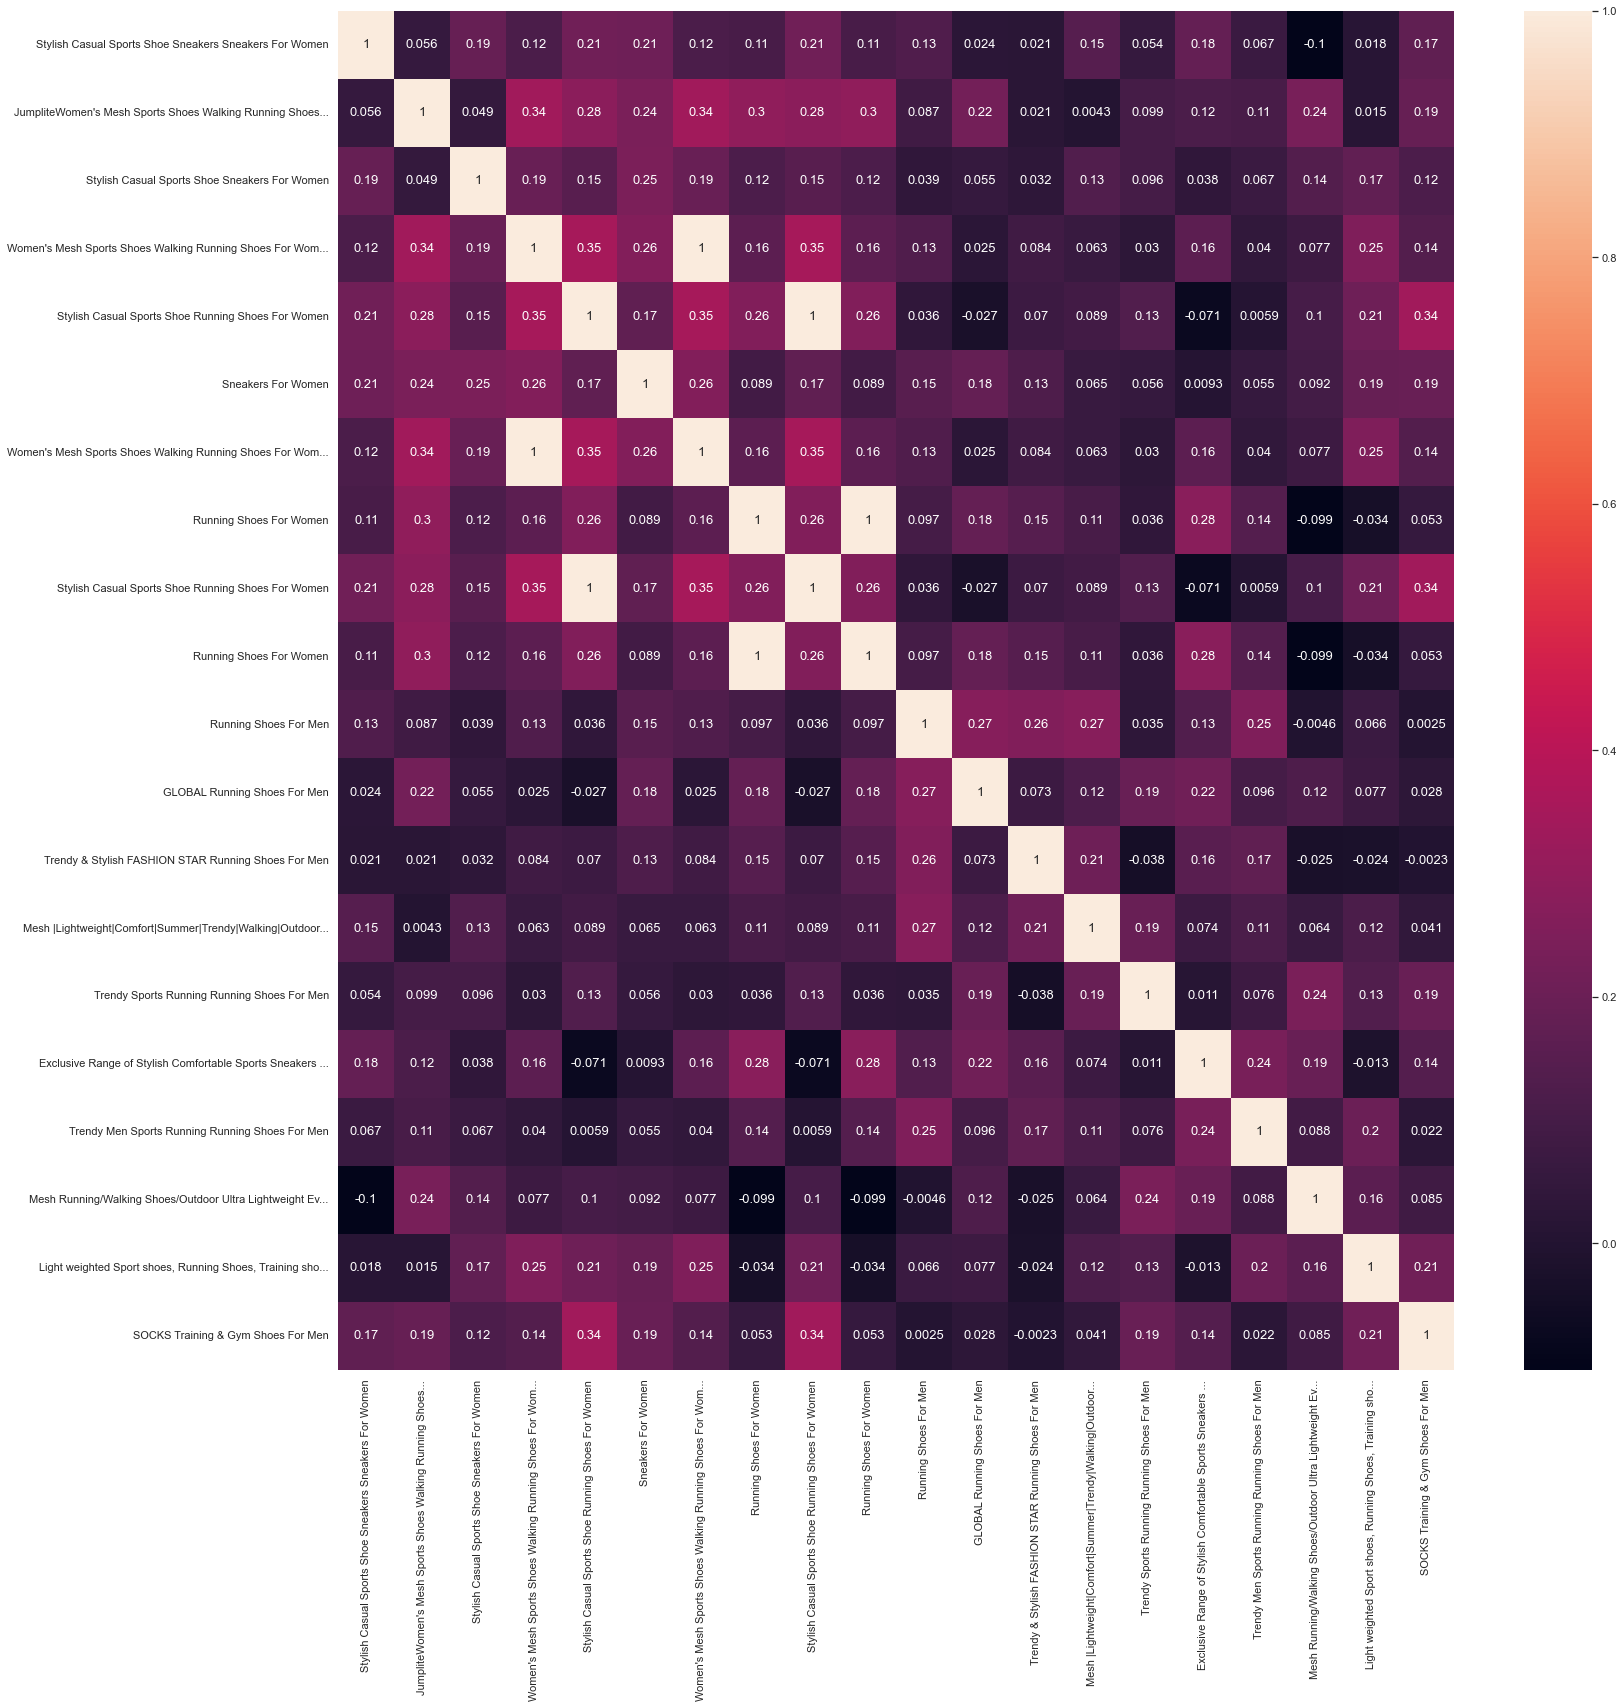

In [44]:
mapp(Sport_shoes)

In [23]:
pip install anvil-uplink


  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [24]:
import anvil.server

anvil.server.connect("BW4AO4UNCJONHSE6OYM24GSI-RDPMK2K6AD2ZLR3W")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment" as SERVER


In [25]:
from keras_preprocessing.image import load_img

In [26]:
category, gender= srp.CM_Models('men', img_path)

In [27]:
import anvil.media

In [28]:
#  DISPLAYING ITEMS BASED ON THE GENDER
@anvil.server.callable
def display_items(gender):
    items = []
    for data in dataset:
        if data['Gender'].lower() == gender.lower():
            items.append(data)
            
    return items

In [29]:
#  PREDICTING IMAGE FASHION TYPE
@anvil.server.callable
def classify_image(category, img_path):
    with anvil.media.TempFile(img_path) as img:
        category, gender = srp.CM_Models(category, img)
        
    return category, gender 

In [30]:
#  DISPLAYING ITEMS BASED ON THE CNN PREDICTION
@anvil.server.callable
def display_item(category, gender):
    display_items = srp.display_classified(dataset, category, gender)
        
    return display_items

In [31]:
# ITEM RECOMMENDATION
item_len = 10
@anvil.server.callable
def item_recommendation(category):
    item_recommendations = srp.recommendation(category, item_len)
        
    return item_recommendations